In [2]:
# @inproceedings{cakmak2021spatio,
#         author = {Cakmak, Eren and Plank, Manuel and Calovi, Daniel S. and Jordan, Alex and Keim, Daniel},
#         title = {Spatio-Temporal Clustering Benchmark for Collective Animal Behavior},
#         year = {2021},
#         isbn = {9781450391221},
#         publisher = {Association for Computing Machinery},
#         address = {New York, NY, USA},
#         url = {https://doi.org/10.1145/3486637.3489487},
#         doi = {10.1145/3486637.3489487},
#         booktitle = {Proceedings of the 1st ACM SIGSPATIAL International Workshop on Animal Movement Ecology and Human Mobility},
#         pages = {5–8},
#         numpages = {4},
#         location = {Beijing, China},
#         series = {HANIMOB '21}
# }

In [ ]:
# the code is based on the following: https://github.com/eren-ck/st_dbscan/blob/master/README.md

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from st_dbscan import ST_DBSCAN
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import Normalize


file_path = r"C:\Users\ainii\OneDrive\Documents\TempSpa\locations\sortedfiles\ST-DBSCAN\eventdata\L468_events.csv" # add file path
df_468 = pd.read_csv(file_path)
print(df_468.head())

   Unnamed: 0                                            cell_id  event_time  \
0        1290  cancer_cancer20220308_slip3_area2_long_acq_can...       671.5   
1        1291  cancer_cancer20220308_slip3_area2_long_acq_can...       780.5   
2        1292  cancer_cancer20220308_slip3_area2_long_acq_can...      1080.5   
3        1293  cancer_cancer20220308_slip3_area2_long_acq_can...      1464.5   
4        1294  cancer_cancer20220308_slip3_area2_long_acq_can...      1929.0   

   event_length  event_amplitude  event_integrated      cell_x     cell_y  \
0         113.0        -0.007130         -0.584030  343.083624  80.711963   
1           9.0        -0.004721         -0.039449  343.083624  80.711963   
2         421.0         0.011538          3.111402  343.083624  80.711963   
3          49.0        -0.016741         -0.533458  343.083624  80.711963   
4          12.0        -0.004890         -0.054680  343.083624  80.711963   

        std  expt stage                                 

In [6]:
# Extract coordinates, time values and slip area
x_values_468 = df_468.iloc[:, 6].values
y_values_468 = df_468.iloc[:, 7].values
time_values_468 = df_468.iloc[:, 2].values
slip_area_468 = df_468.iloc[:, 12].astype(str)

# Normalise distance values
scaler = MinMaxScaler() # Initialize the MinMaxScaler
x_values_rescaled_468 = x_values_468.reshape(-1, 1)
y_values_rescaled_468 = y_values_468.reshape(-1, 1)

x_normalized_468 = scaler.fit_transform(x_values_rescaled_468)
y_normalized_468 = scaler.fit_transform(y_values_rescaled_468)

# x_normalized = df.iloc[:, 6].values # normalisation and not normalising gives the same results
# y_normalized = df.iloc[:, 7].values

# Create new DataFrame with normalised coordinates and time
coordinates_data_468 = pd.DataFrame({'X': x_normalized_468.flatten(), 'Y': y_normalized_468.flatten()})

# Add slip area to coordinates data
data_468 = pd.concat([pd.DataFrame({'Time': time_values_468}), coordinates_data_468, slip_area_468], axis=1) # data must be in the following order: Time 

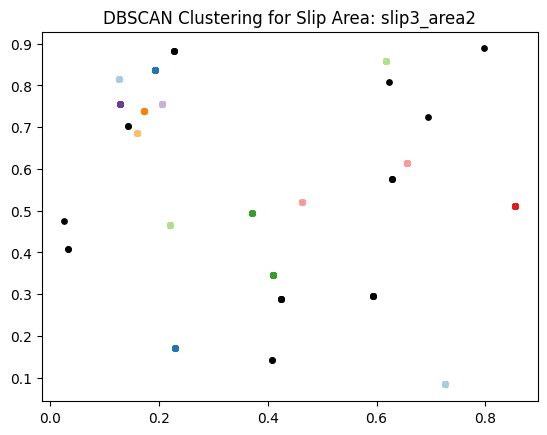

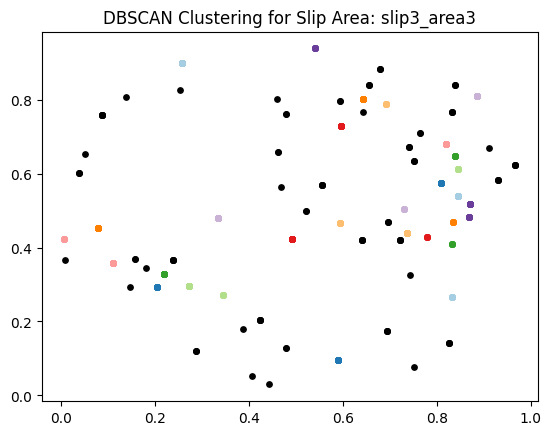

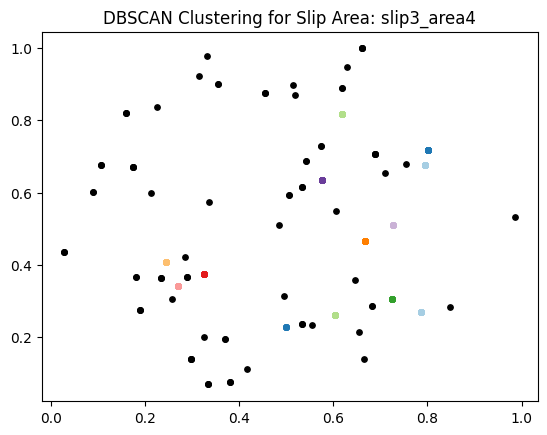

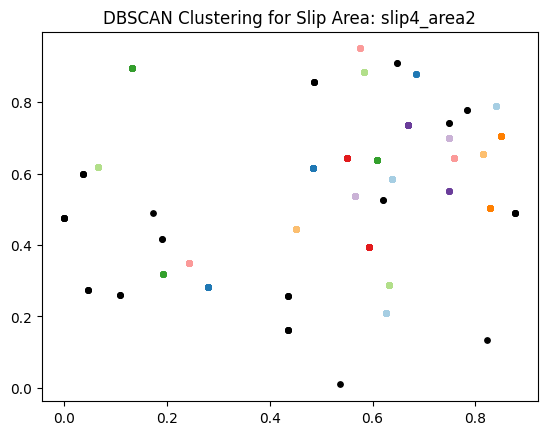

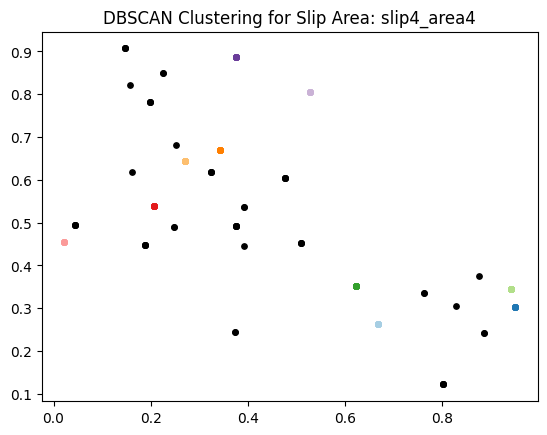

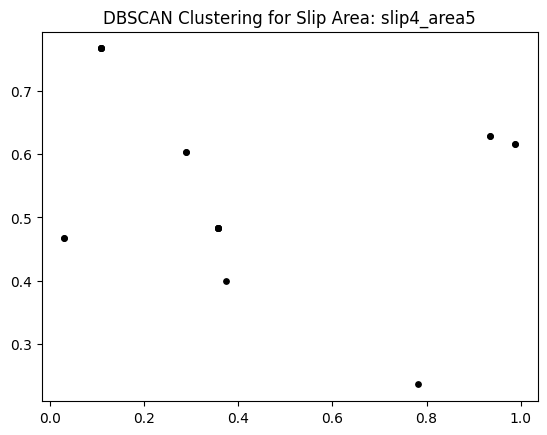

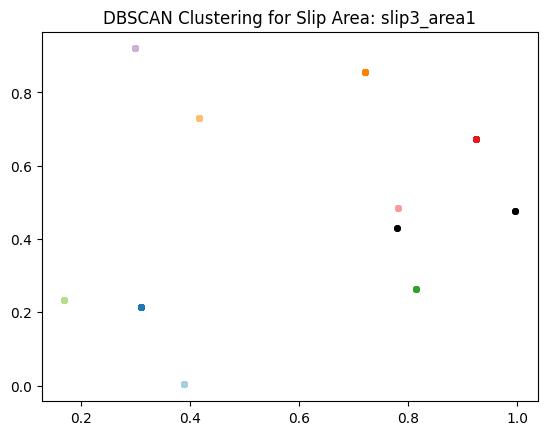

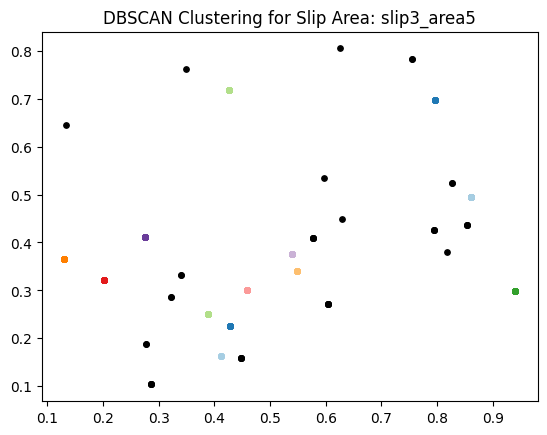

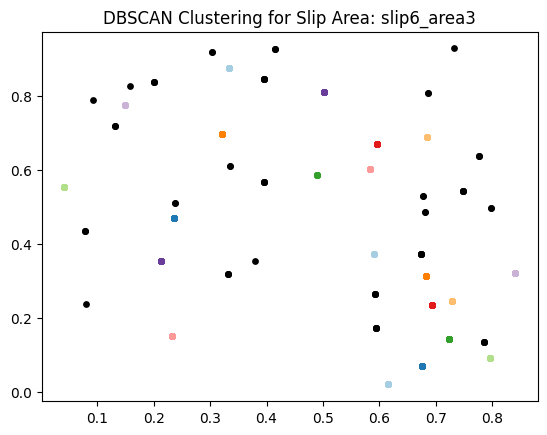

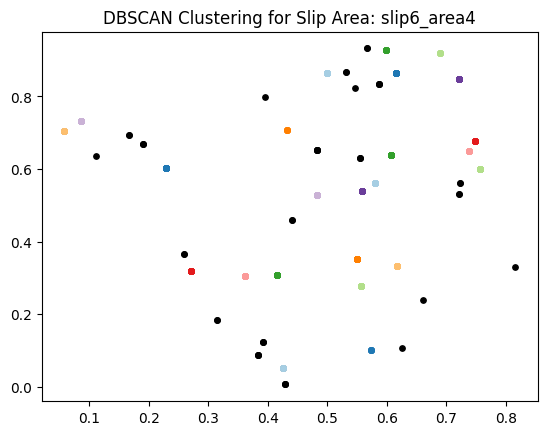

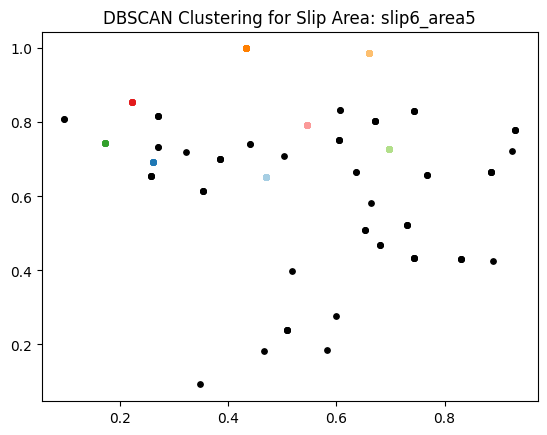

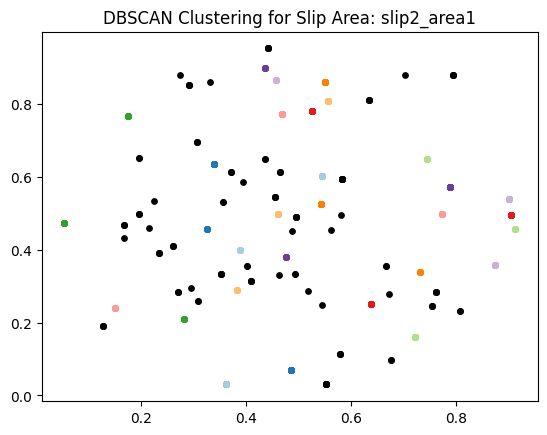

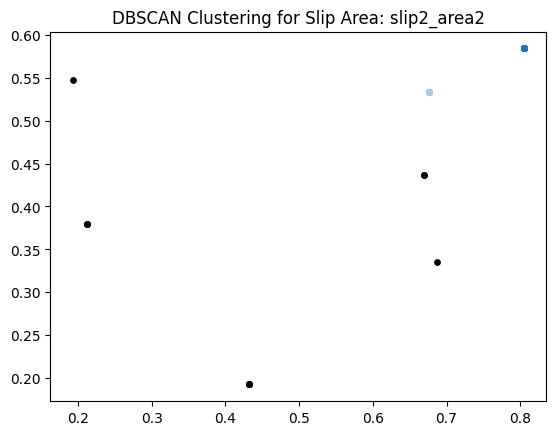

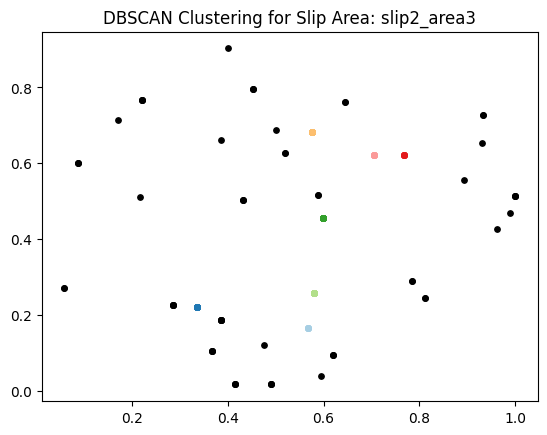

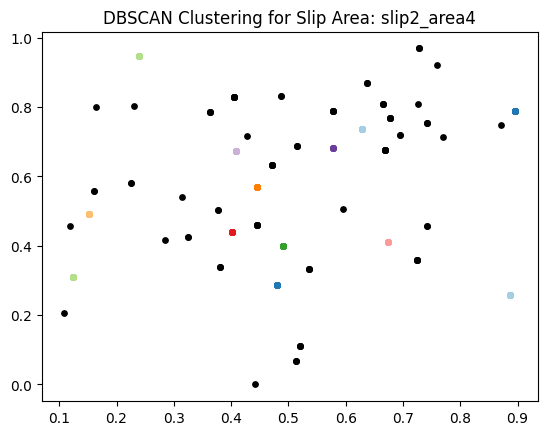

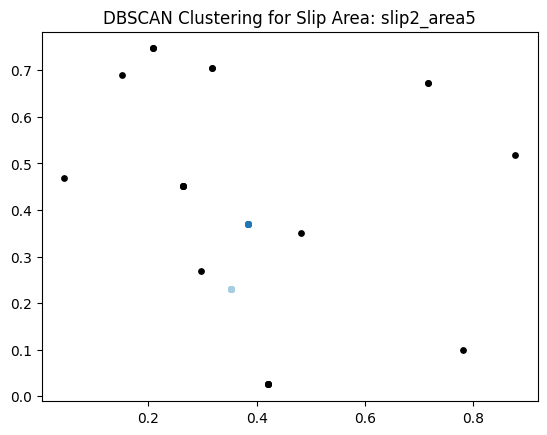

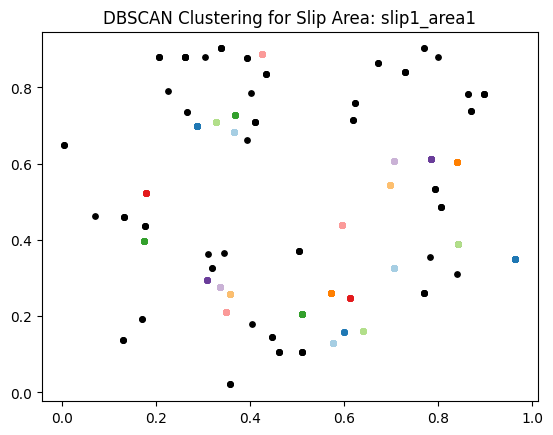

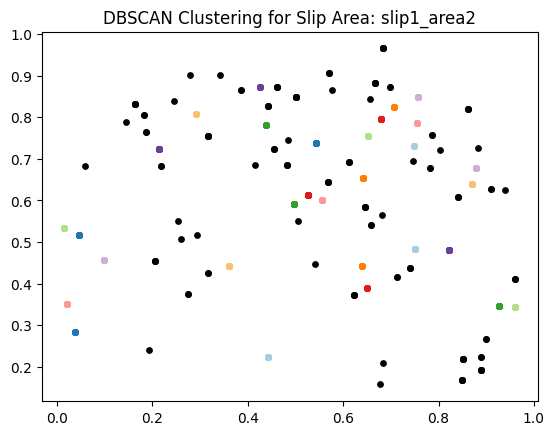

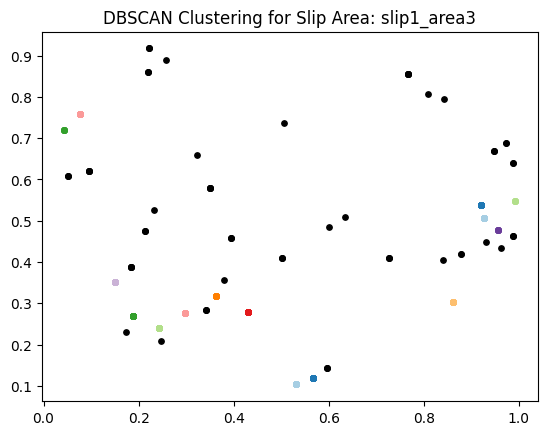

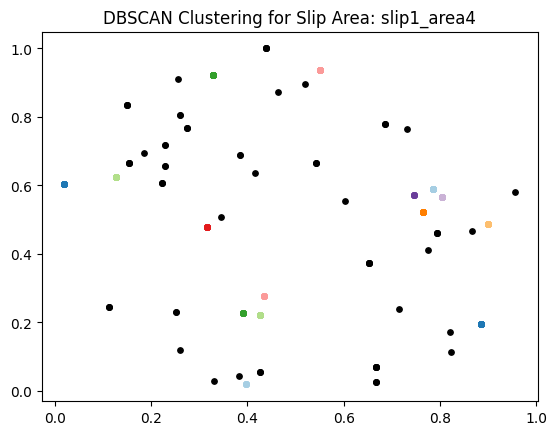

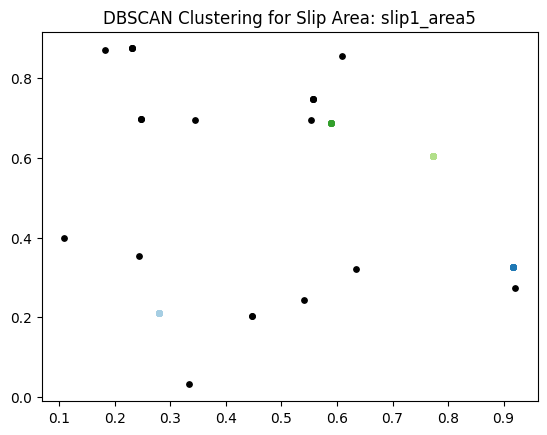

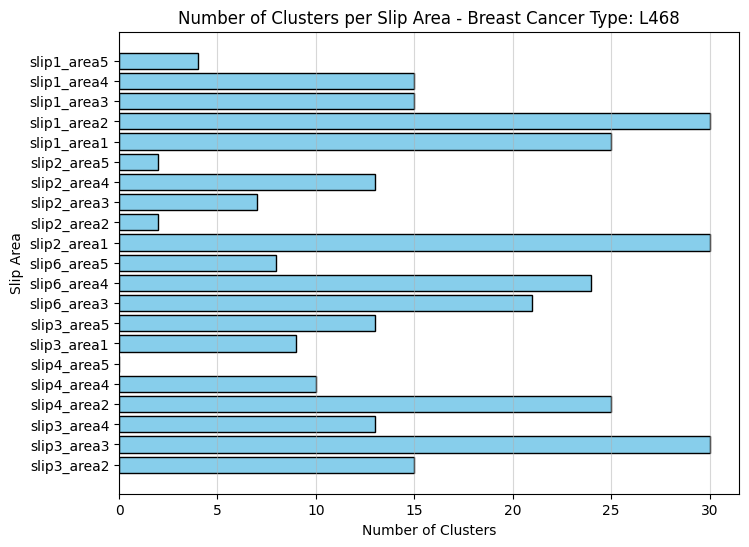

In [10]:
# Plot function
def plot(coord_values, labels):
    colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']

    for i in range(-1, len(set(labels))):
        if i == -1:
            col = [0, 0, 0, 1]
        else:
            col = colors[i % len(colors)]

        clust = coord_values[labels == i]
        plt.scatter(clust.iloc[:, 0], clust.iloc[:, 1], c=[col], s=15)
    plt.show()

# Perform ST-DBSCAN for each slip area
slip_area_combinations_468 = data_468['Slip_Area'].unique()
num_clusters_468 = []

for slip_area in slip_area_combinations_468:
    subset = data_468[data_468['Slip_Area'] == slip_area]  
    
    # Plot for each slip
    # plt.scatter(subset['X'], subset['Y'])
    # plt.title(f'Excitation Plot - {slip_area}')
    # plt.xlabel('X Coordinate')
    # plt.ylabel('Y Coordinate')
    # plt.show()

    st_dbscan_468 = ST_DBSCAN(eps1=0.01, eps2=2000, min_samples=6) 
    #eps1 = distance radius, eps2  = time radius, min_samples = min number of points for a core point
    #to calculate optimum min_sample, use 2*dimensions(D), hence for three dimensions, use 6
    coord_values_468 = subset.iloc[:, :-1]  # Select columns 0, 1, and 2
    st_dbscan_468.fit(coord_values_468)
    
    cluster_labels_468 = st_dbscan_468.labels
    
    # Plot clusters for each slip area
    plt.title("DBSCAN Clustering for Slip Area: " + slip_area) 
    plot(coord_values_468.iloc[:, 1:], cluster_labels_468)
    num_clusters_468.append(len(np.unique(cluster_labels_468[cluster_labels_468 != -1])))

# Plot histogram
plt.figure(figsize=(8, 6))
plt.barh(slip_area_combinations_468, num_clusters_468, color='skyblue', edgecolor='black')
plt.xlabel('Number of Clusters')
plt.ylabel('Slip Area')
plt.title(f'Number of Clusters per Slip Area - Breast Cancer Type: L468')
plt.grid(axis='x', alpha=0.5)
plt.show()


Optimal epsilon value for slip3_area2 is: 0.0
Optimal epsilon value for slip3_area3 is: 0.04271264772615104
Optimal epsilon value for slip3_area4 is: 0.0282697291980668
Optimal epsilon value for slip4_area2 is: 0.0
Optimal epsilon value for slip4_area4 is: 0.0
Optimal epsilon value for slip4_area5 is: 0.0
Optimal epsilon value for slip3_area1 is: None
Optimal epsilon value for slip3_area5 is: 0.0
Optimal epsilon value for slip6_area3 is: 0.0
Optimal epsilon value for slip6_area4 is: 0.0
Optimal epsilon value for slip6_area5 is: 0.0
Optimal epsilon value for slip2_area1 is: 0.04763611112669137
Optimal epsilon value for slip2_area2 is: 0.0
Optimal epsilon value for slip2_area3 is: 0.0


c:\Users\ainii\AppData\Local\Programs\Python\Python310\lib\site-packages\kneed\knee_locator.py:225: RuntimeWarning: invalid value encountered in divide
  return (a - min(a)) / (max(a) - min(a))


Optimal epsilon value for slip2_area4 is: 0.0
Optimal epsilon value for slip2_area5 is: 0.0
Optimal epsilon value for slip1_area1 is: 0.0
Optimal epsilon value for slip1_area2 is: 0.051228120017692974
Optimal epsilon value for slip1_area3 is: 0.0
Optimal epsilon value for slip1_area4 is: 0.0
Optimal epsilon value for slip1_area5 is: 0.14177341294885856


c:\Users\ainii\AppData\Local\Programs\Python\Python310\lib\site-packages\kneed\knee_locator.py:390: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=figsize)


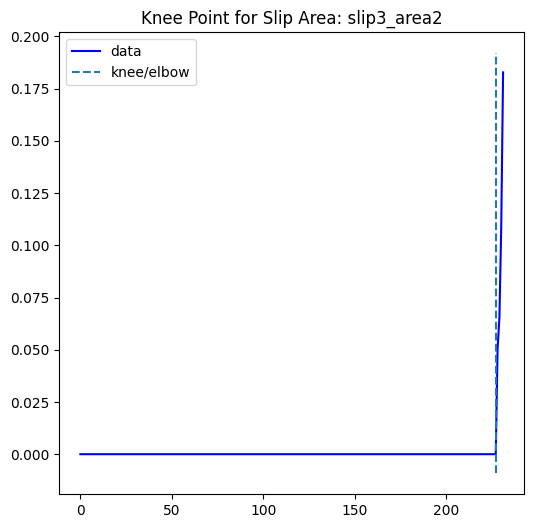

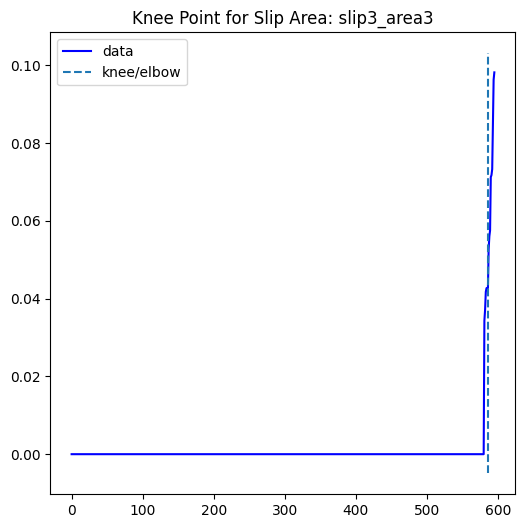

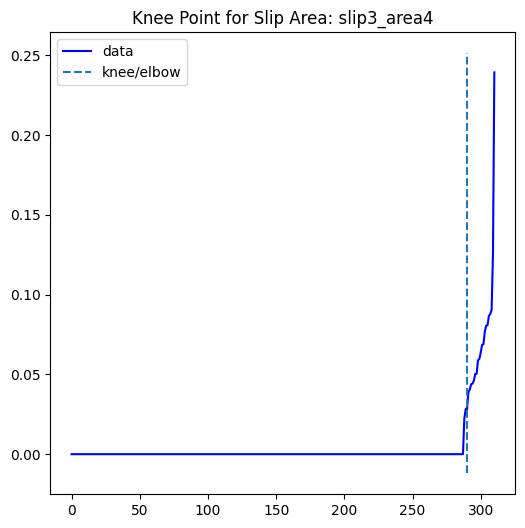

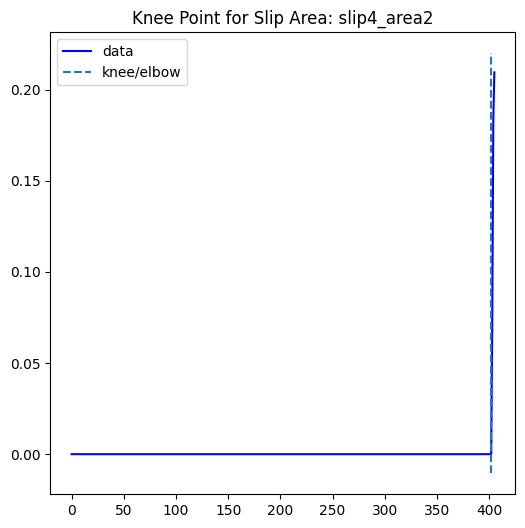

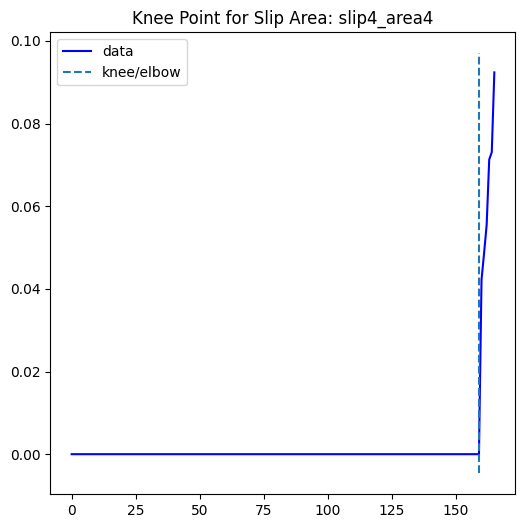

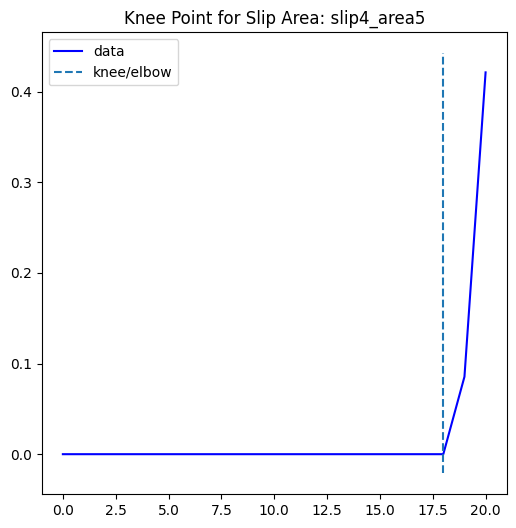

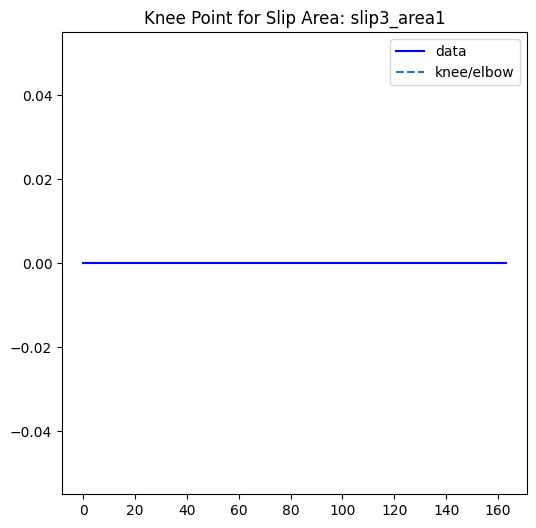

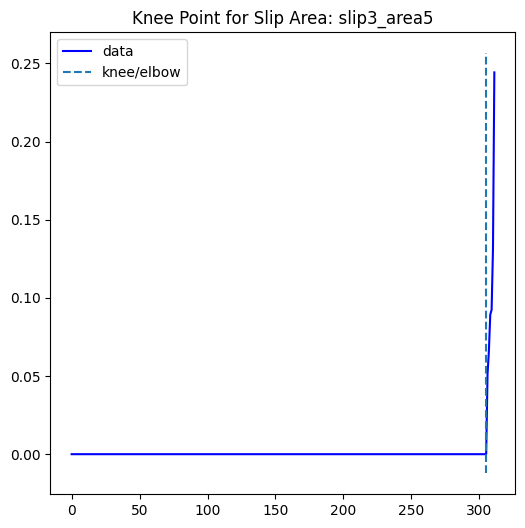

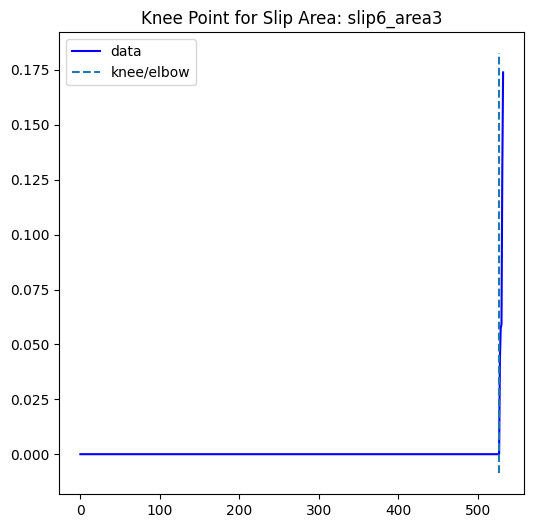

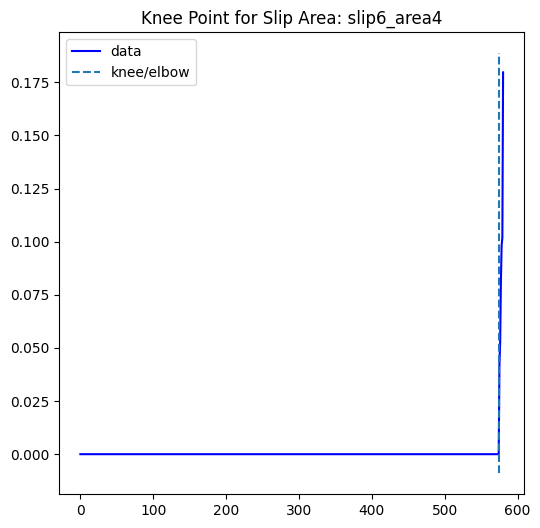

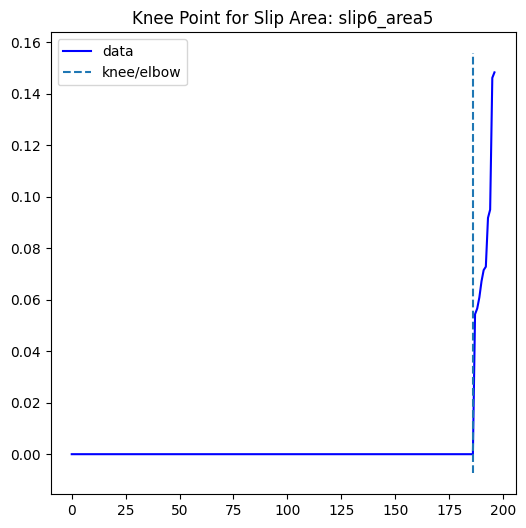

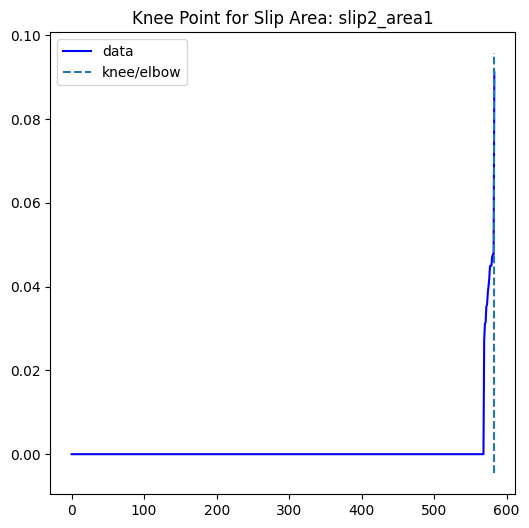

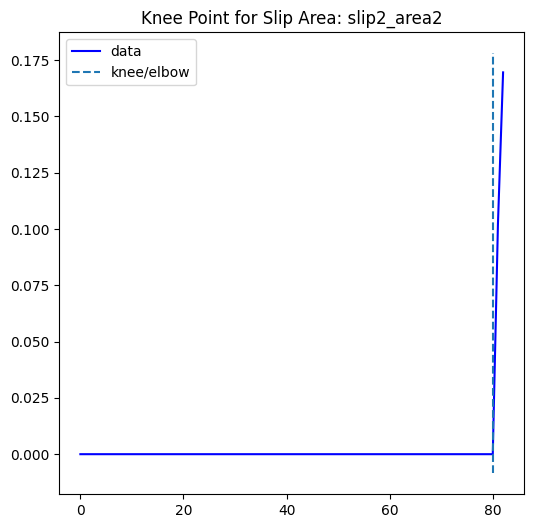

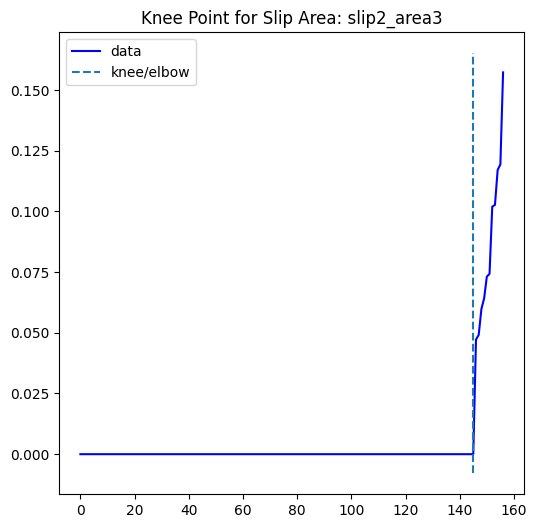

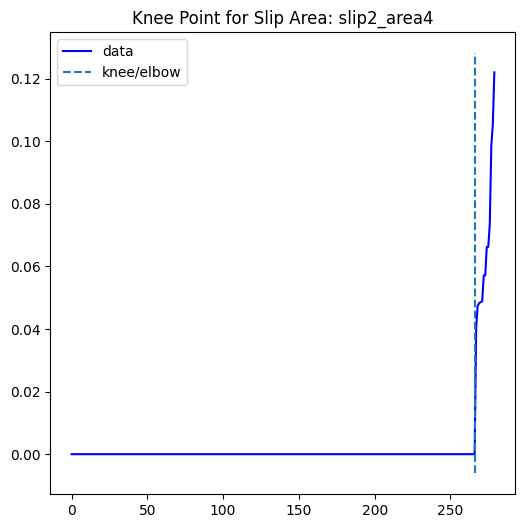

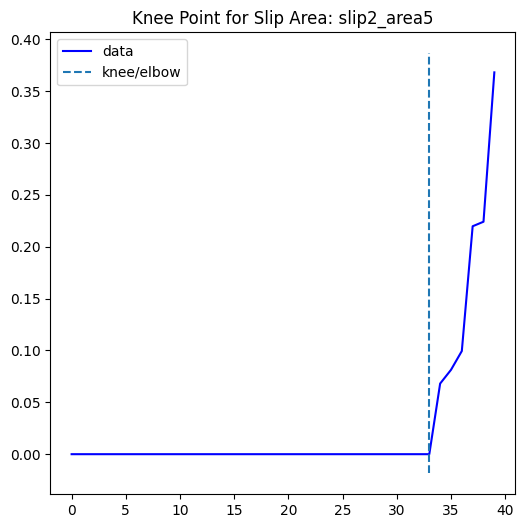

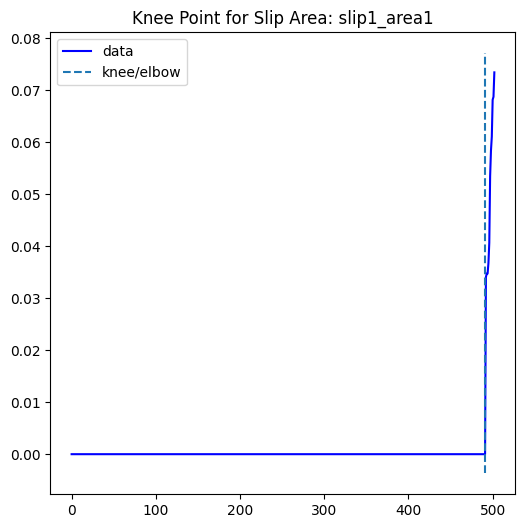

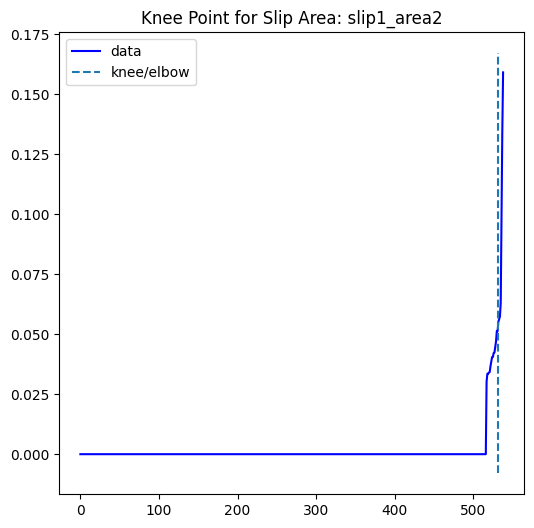

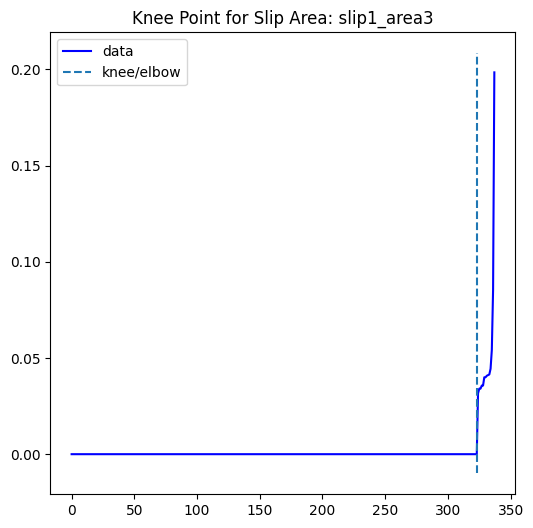

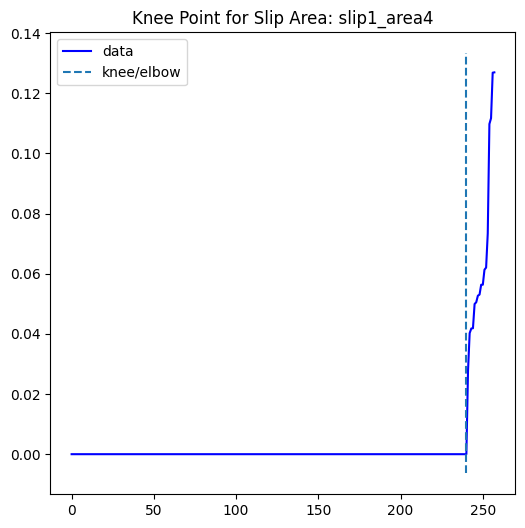

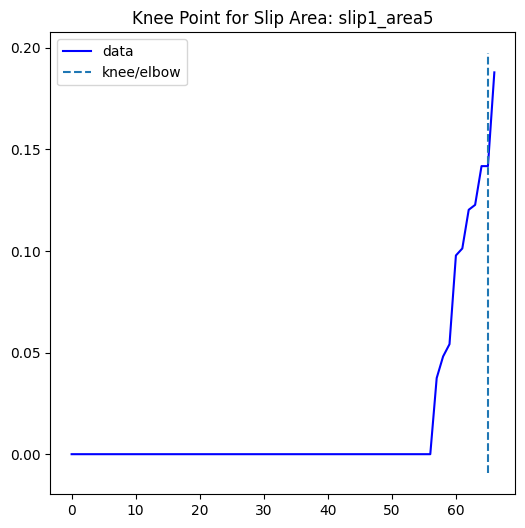

In [163]:
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
import numpy as np

slip_area_combinations_468 = data_468['Slip_Area'].unique()
for slip_area in slip_area_combinations_468:
    subset = data_468[data_468['Slip_Area'] == slip_area]
    subset_coord_468 = subset[['X', 'Y']]  # Assuming 'X' and 'Y' are the column names for coordinates
    neighbors = NearestNeighbors(n_neighbors=4) # k-means for 2 dimensions hence 4
    neighbors_fit = neighbors.fit(subset_coord_468)
    distances, indices = neighbors_fit.kneighbors(subset_coord_468)
    distances = np.sort(distances, axis=0)
    distances = distances[:, 1]

    # Define the range for the x-axis
    start_index = 0
    end_index = len(distances)
    x_axis_range = range(start_index, end_index)

    # Find the knee point
    kneedle = KneeLocator(x_axis_range, distances[start_index:end_index], curve='convex', direction='increasing')
    print("Optimal epsilon value for", slip_area, "is:", kneedle.knee_y)
    
    # Modify the plot title to include the slip area
    plot_title = "Knee Point for Slip Area: " + slip_area
    
    # Plot the knee point with modified title
    kneedle.plot_knee(title=plot_title)


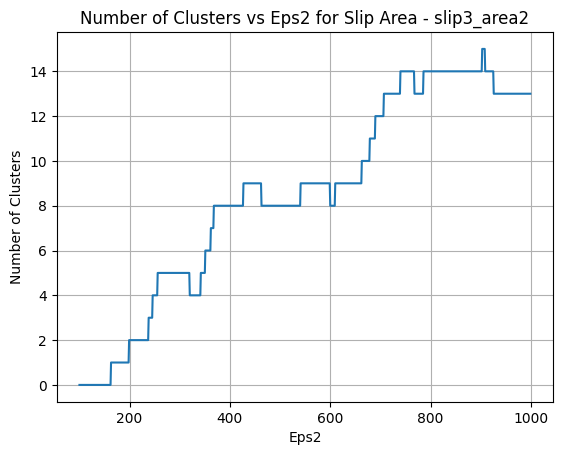

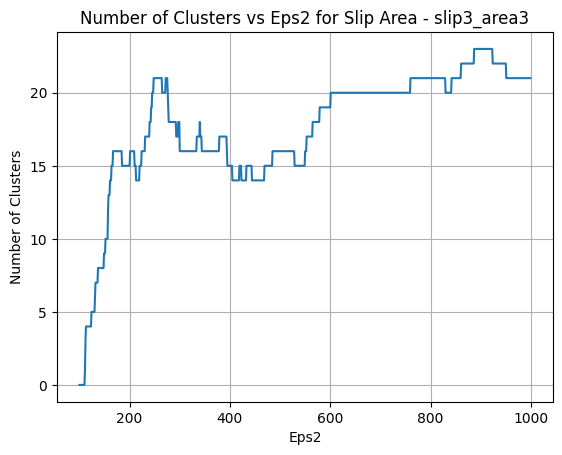

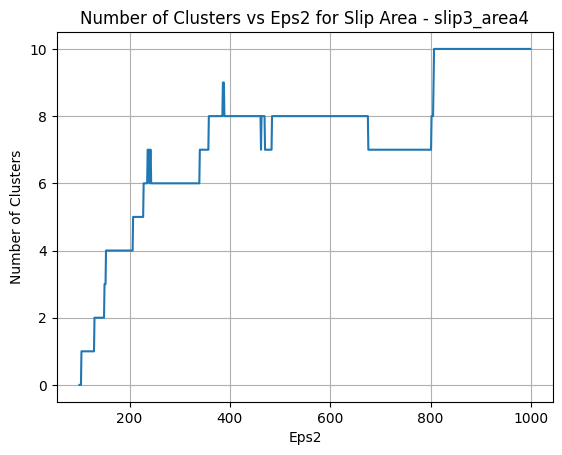

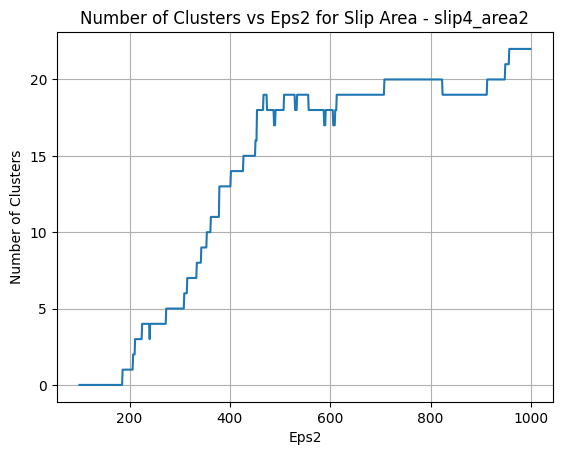

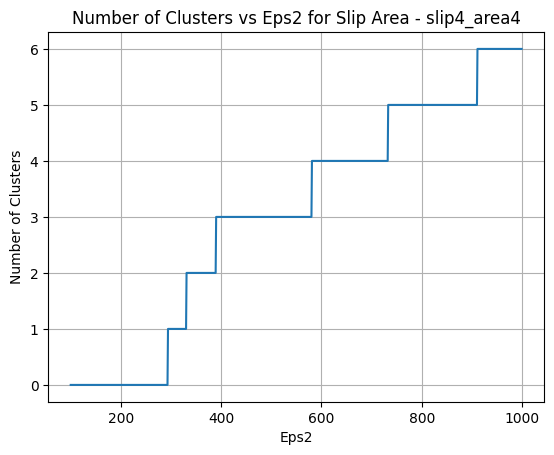

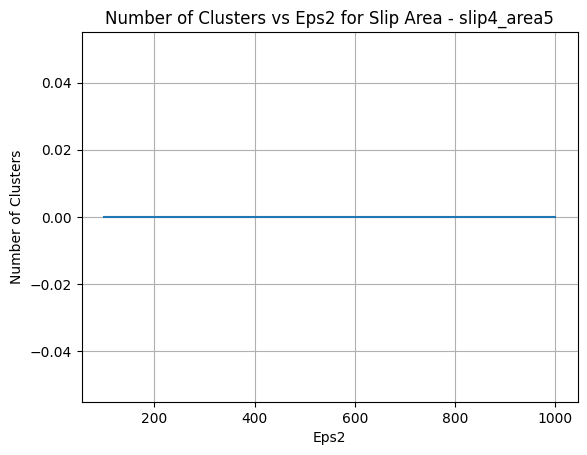

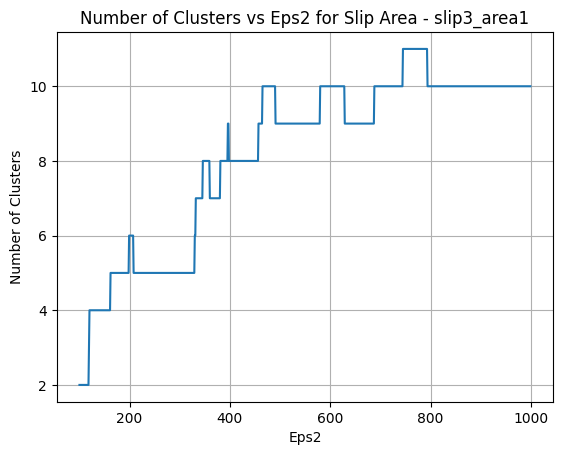

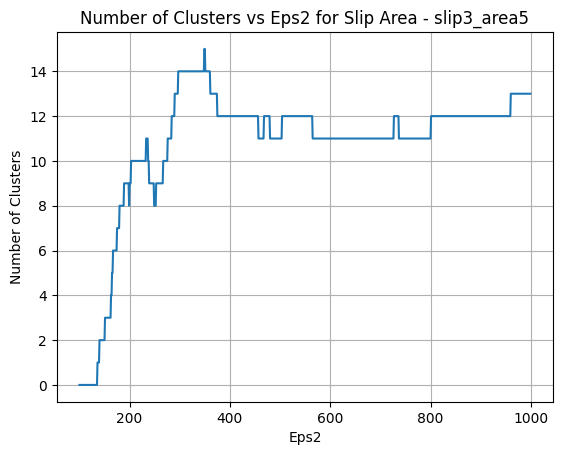

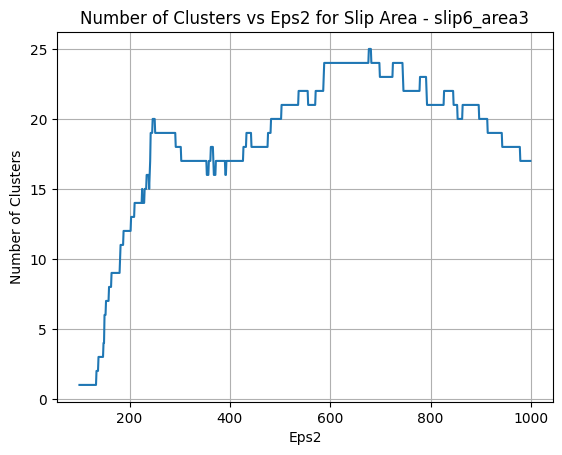

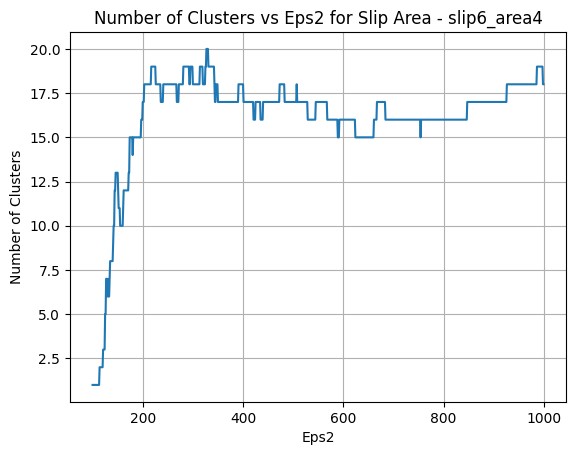

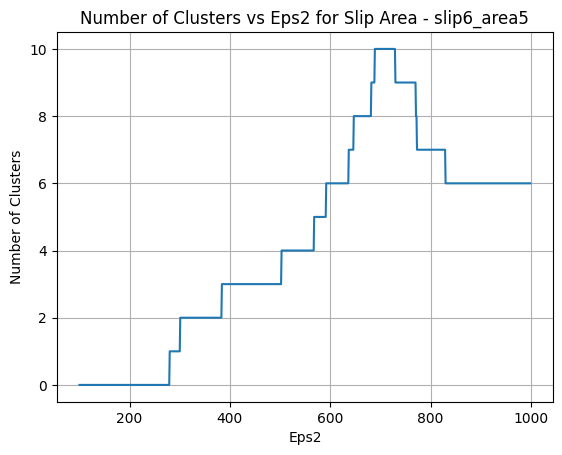

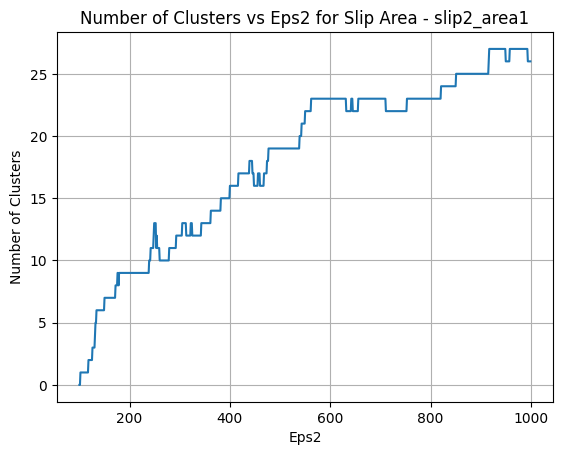

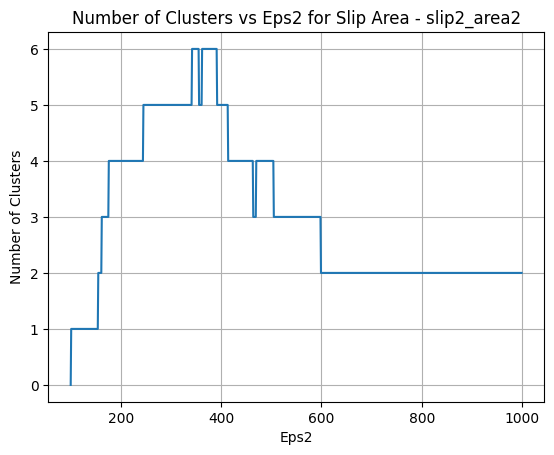

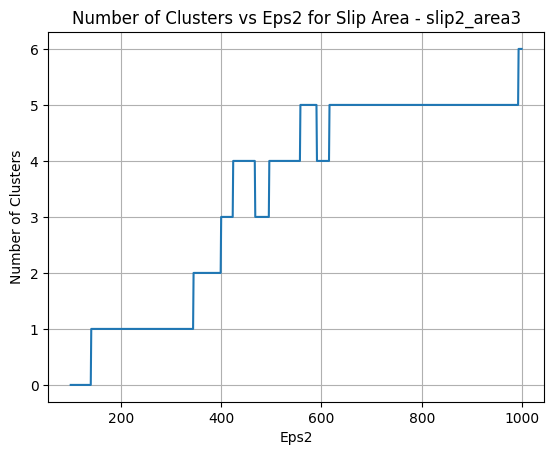

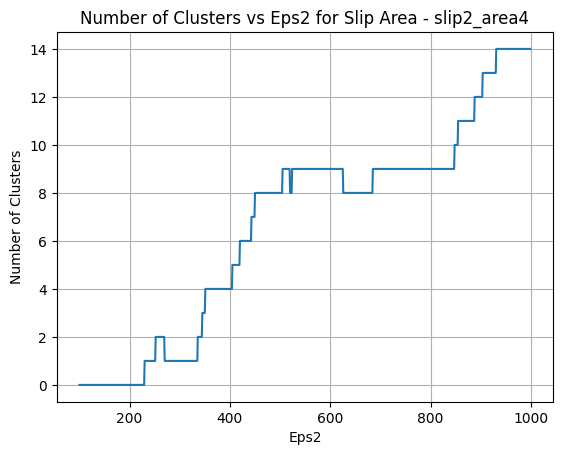

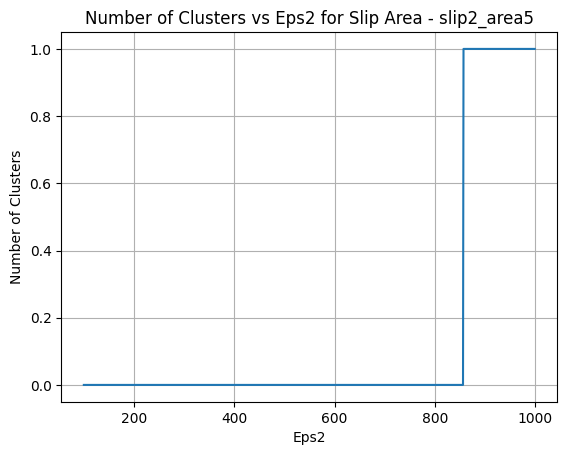

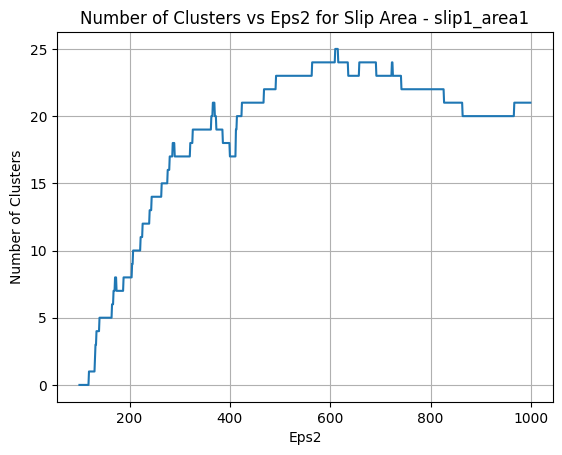

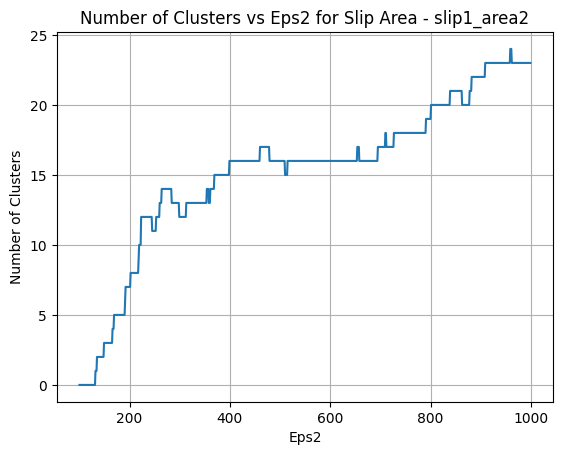

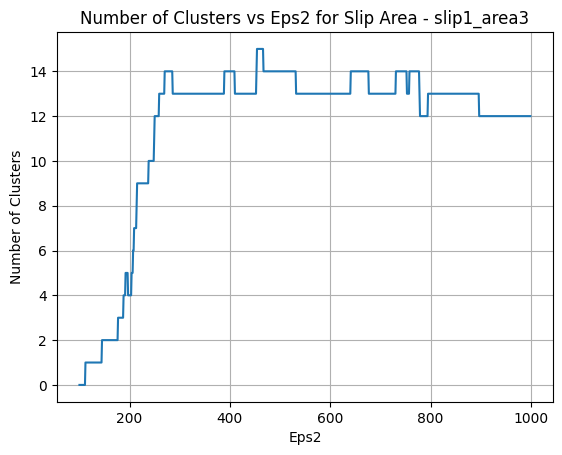

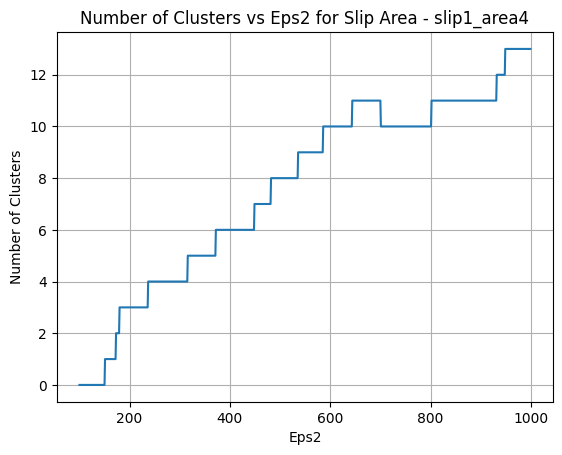

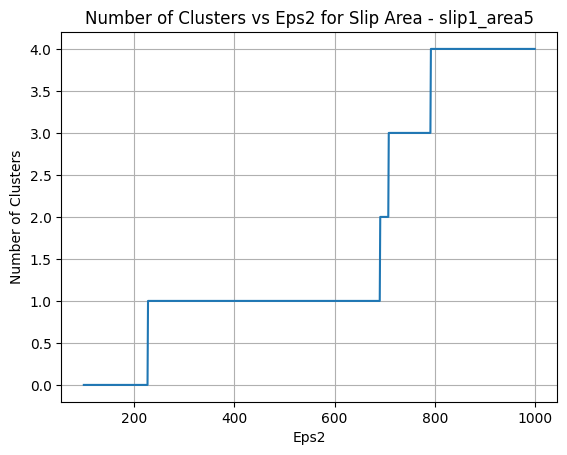

In [172]:
# Find optimum eps2
# Plotted range of epsilon values agains number of clusters
# Used 100 ms as this is time it takes for calcium ion cell signalling
slip_area_combinations_468 = data_468['Slip_Area'].unique()
num_clusters_468 = []

for slip_area in slip_area_combinations_468:
    # Extract subset for each slip area
    subset = data_468[data_468['Slip_Area'] == slip_area]  

    # Define range of eps2 values
    eps2_values = range(100,1000)  # Range from 0 to 100, inclusive
    num_clusters_for_eps2 = []  # Store the number of clusters for each eps2 value
    
    for eps2 in eps2_values:
        # Apply ST_DBSCAN for each eps2 value
        st_dbscan_468 = ST_DBSCAN(eps1=0.03, eps2=eps2, min_samples=6) 
        coord_values_468 = subset.iloc[:, :3]  # Extract coordinates
        st_dbscan_468.fit(coord_values_468)  # Fit ST_DBSCAN
        cluster_labels_468 = st_dbscan_468.labels
        
        # Count number of clusters (excluding noise)
        num_clusters_for_eps2.append(len(np.unique(cluster_labels_468[cluster_labels_468 != -1])))
    
    # Plotting the number of clusters vs eps2 for the slip area
    plt.plot(eps2_values, num_clusters_for_eps2)
    plt.title(f'Number of Clusters vs Eps2 for Slip Area - {slip_area}')
    plt.xlabel('Eps2')
    plt.ylabel('Number of Clusters')
    plt.grid(True)
    plt.show()
    
    # Store number of clusters for each eps2 value for this slip area
    num_clusters_468.append(num_clusters_for_eps2)


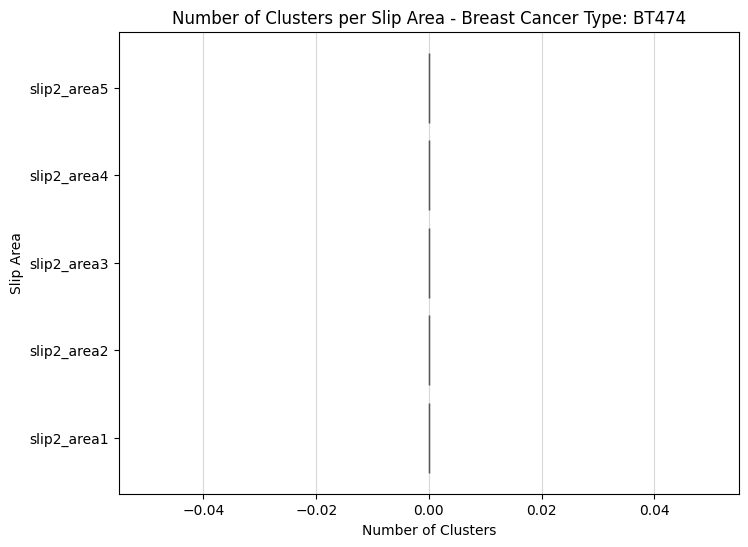

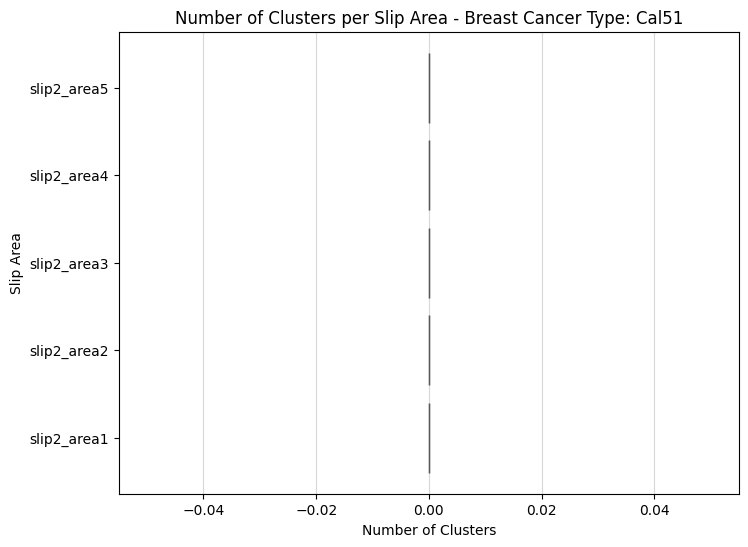

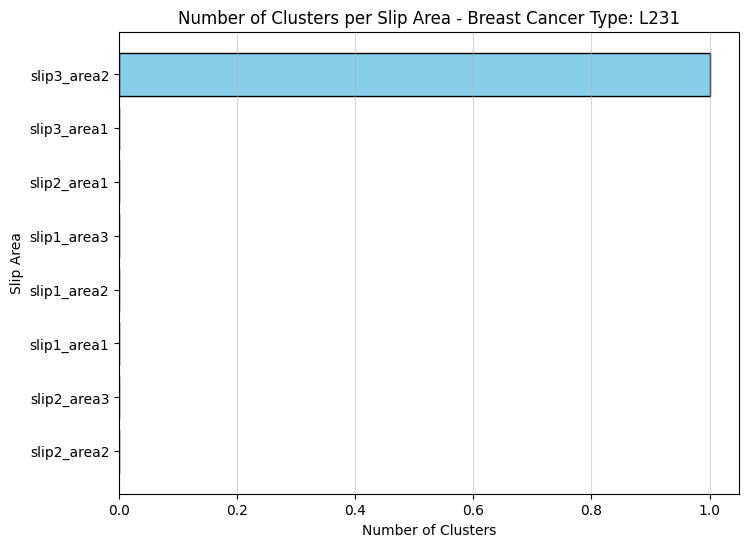

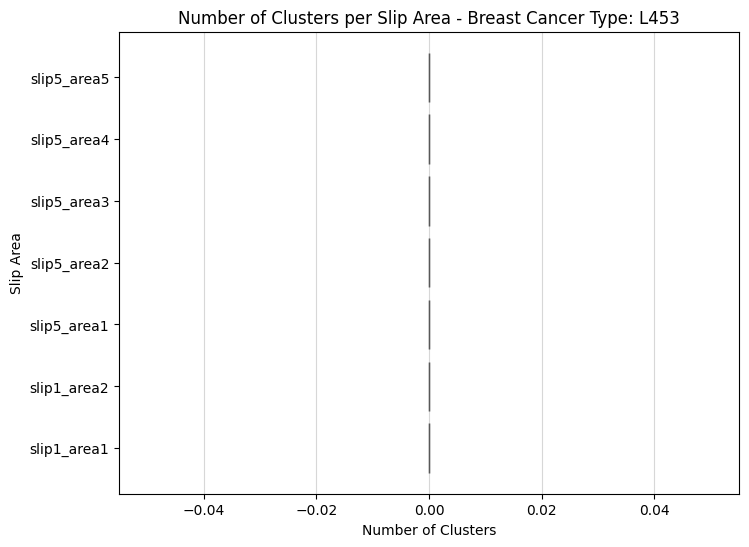

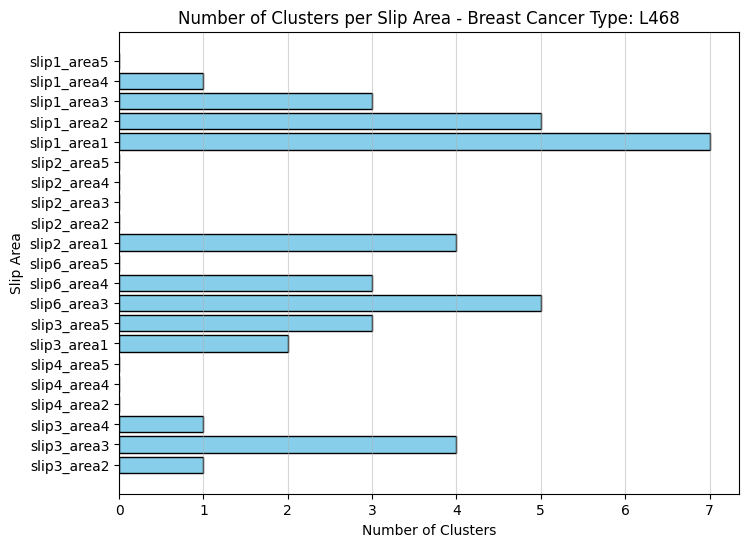

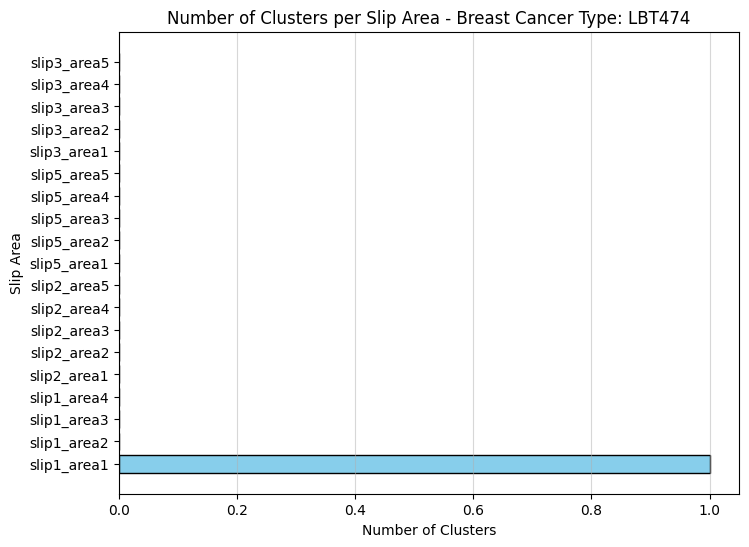

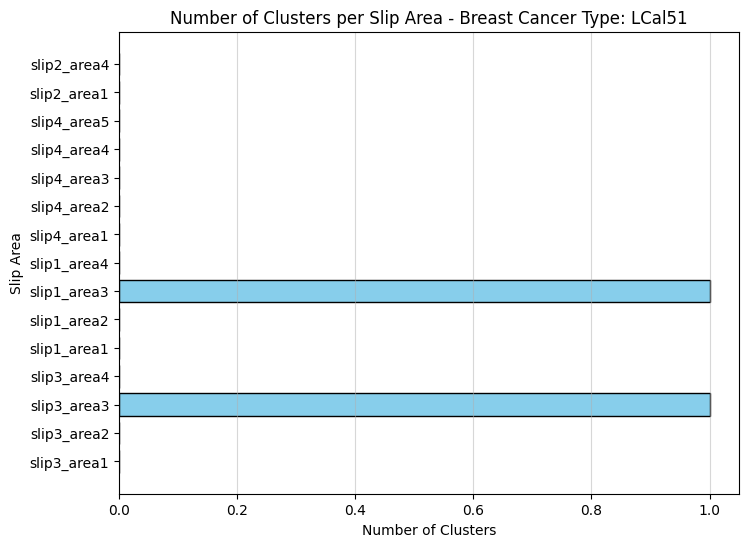

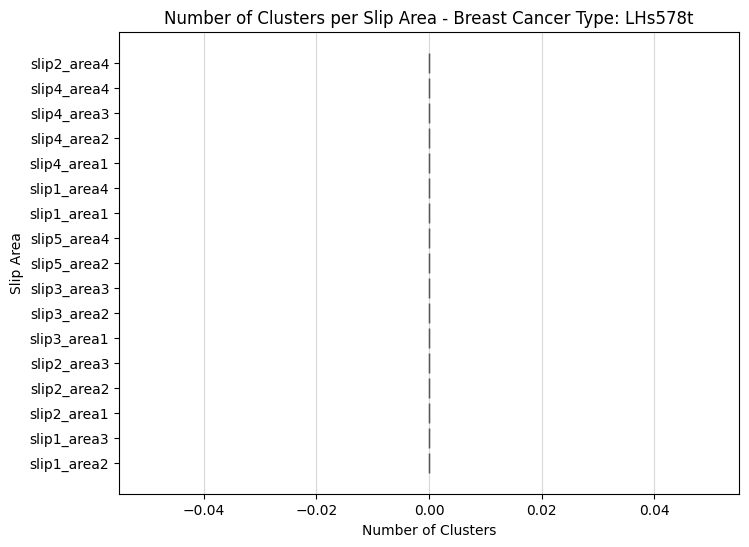

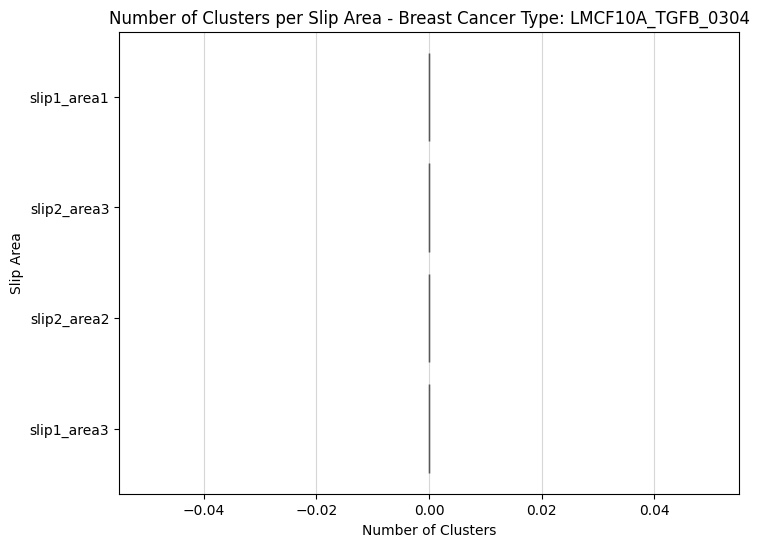

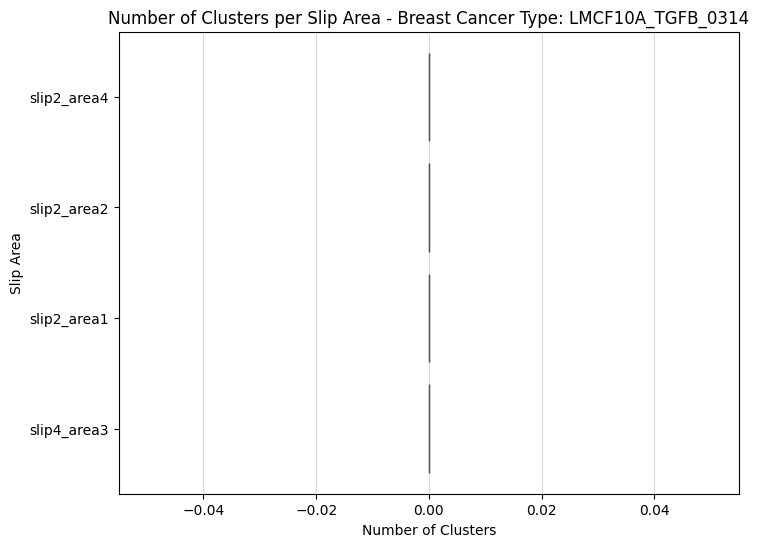

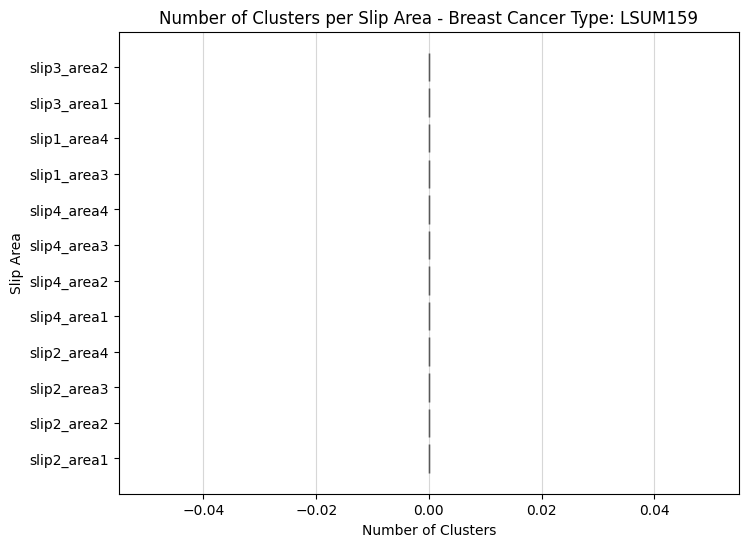

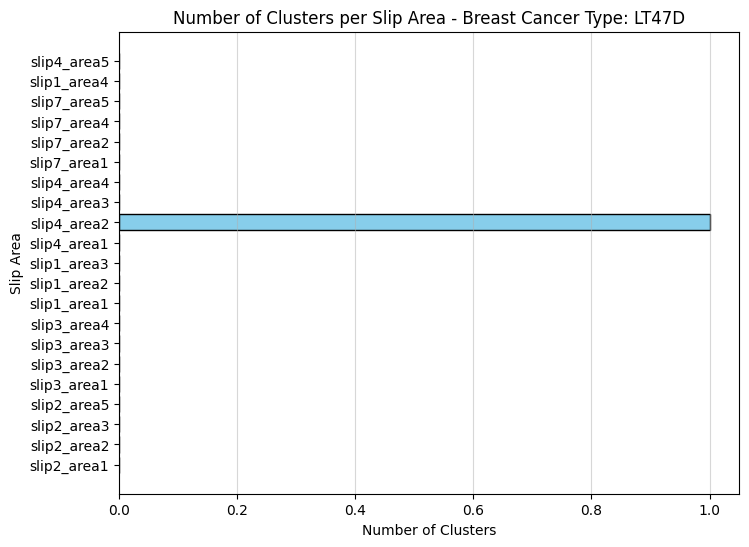

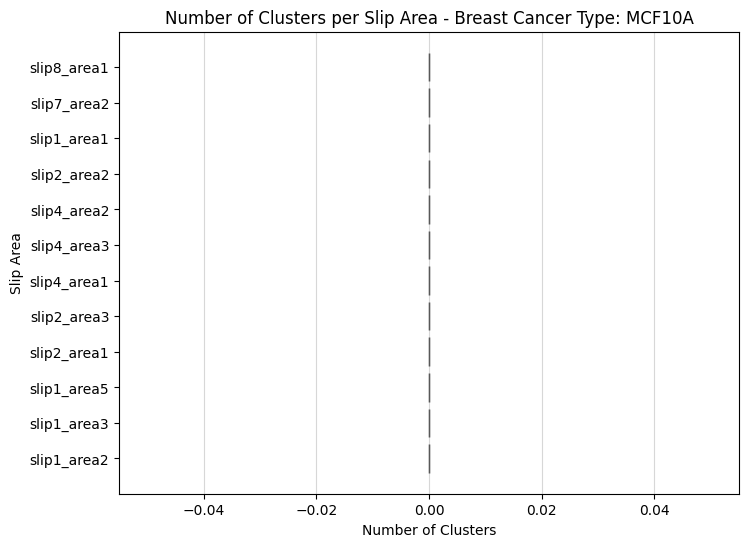

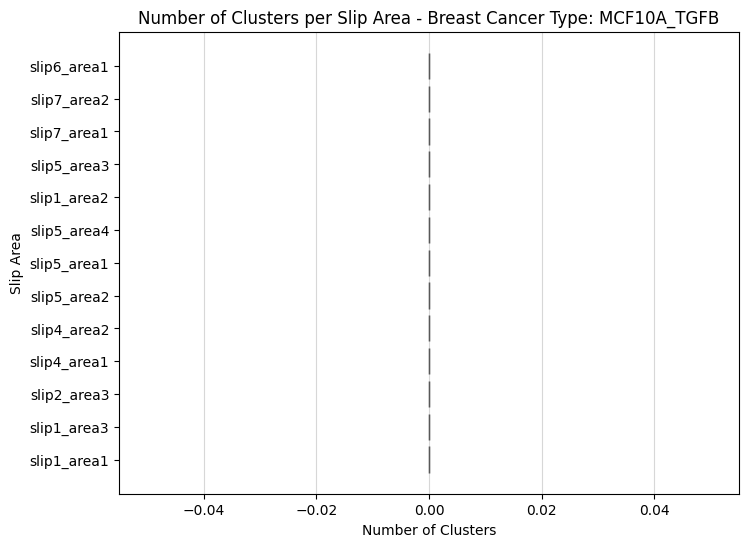

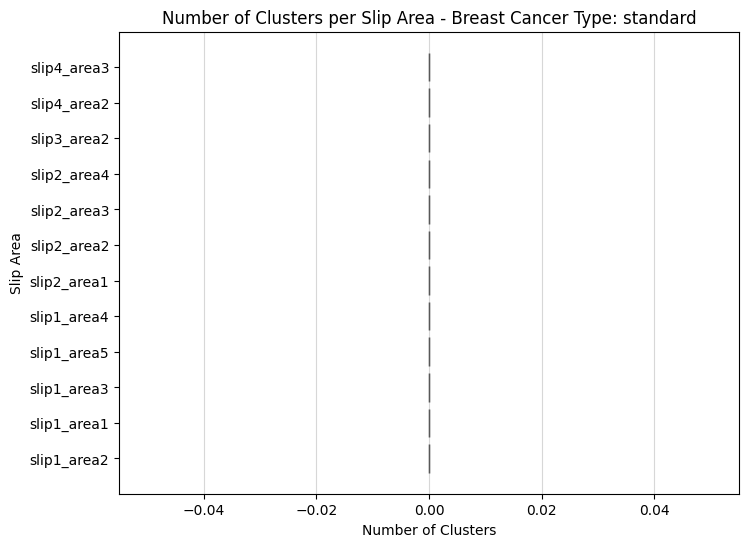

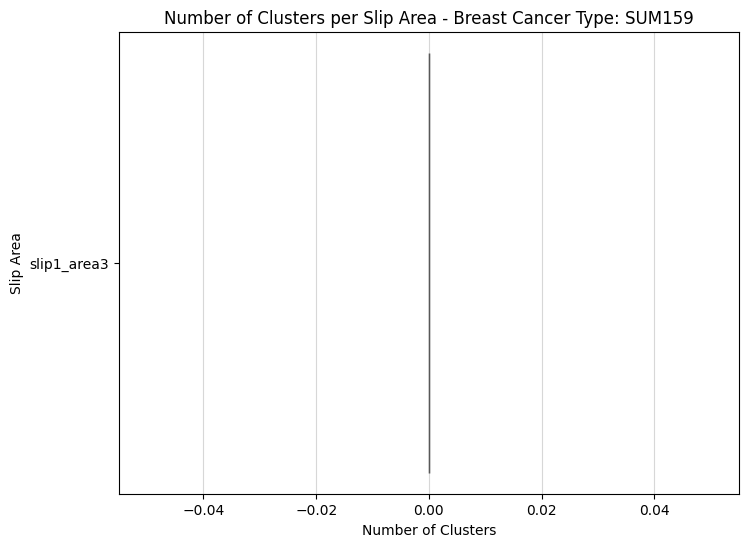

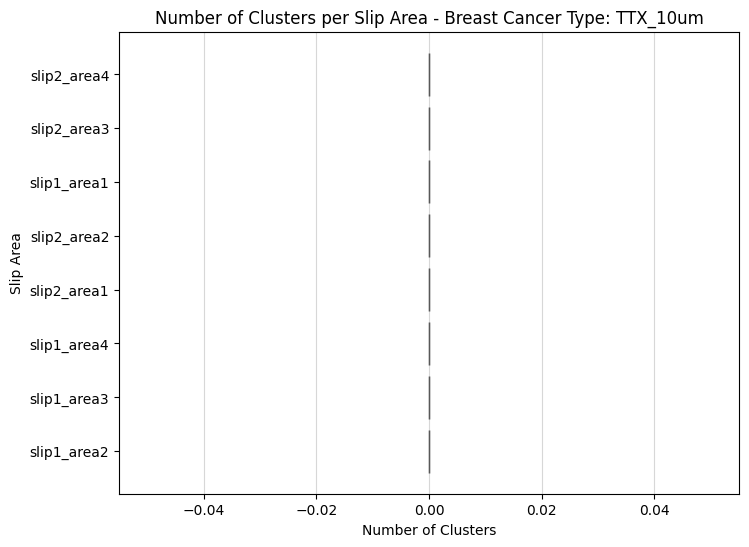

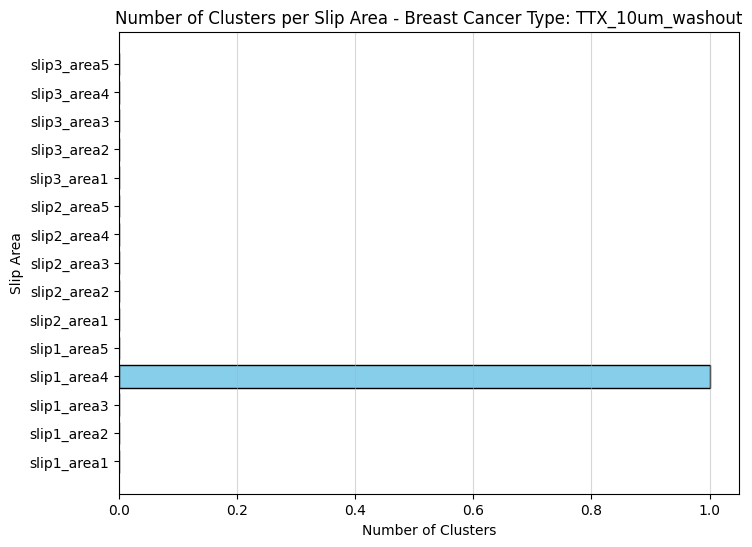

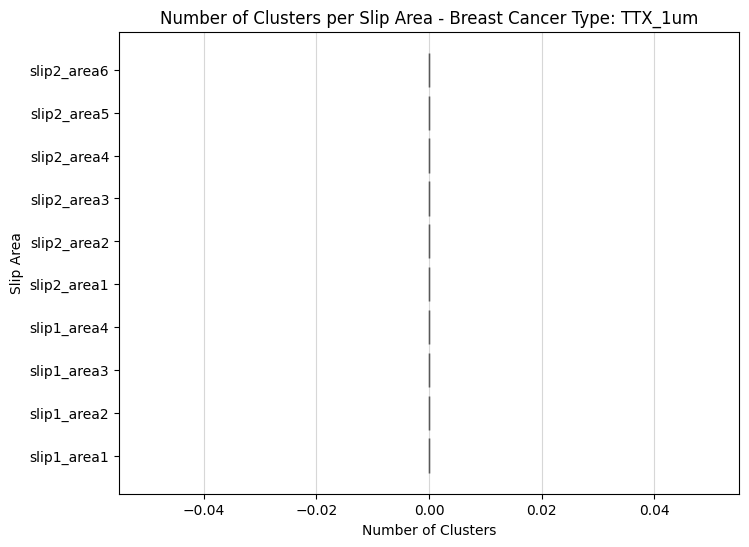

In [166]:
#plot histogram for all breast cancer cell types
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from st_dbscan import ST_DBSCAN

folder_path = r"C:\Users\ainii\OneDrive\Documents\TempSpa\locations\sortedfiles\ST-DBSCAN\eventdata"

# Loop for each file in folder
for filename in os.listdir(folder_path):
    if not filename.endswith('_events.csv'):
        continue

    # Extract breast cancer type name from file name
    cancer_type = filename[:-11]  # Remove "_events.csv" from filename
    file_path = os.path.join(folder_path, filename)
    df = pd.read_csv(file_path)

    # Extract coordinates, time values and slip area
    x_values = df.iloc[:, 6].values
    y_values = df.iloc[:, 7].values
    time_values = df.iloc[:, 2].values
    slip_area = df.iloc[:, 12].astype(str)

    # Normalise distance values
    scaler = MinMaxScaler() # Initialize the MinMaxScaler
    x_values_rescaled = x_values.reshape(-1, 1)
    y_values_rescaled = y_values.reshape(-1, 1)

    x_normalized = scaler.fit_transform(x_values_rescaled)
    y_normalized = scaler.fit_transform(y_values_rescaled)

    # Create new DataFrame with normalised coordinates and time
    coordinates_data = pd.DataFrame({'X': x_normalized.flatten(), 'Y': y_normalized.flatten()})

    # Add slip area to coordinates data
    data = pd.concat([pd.DataFrame({'Time': time_values}), coordinates_data, slip_area], axis=1)
    
    # Perform clustering for each slip area
    slip_area_combinations = data['Slip_Area'].unique()
    num_clusters = []

    for slip_area in slip_area_combinations:
        subset = data[data['Slip_Area'] == slip_area]
        st_dbscan = ST_DBSCAN(eps1=0.05, eps2=100, min_samples=6) # Apply ST-DBSCAN
        coord_values = subset.iloc[:, :3]  # Excluding time and slip area columns
        st_dbscan.fit(coord_values)

        cluster_labels = st_dbscan.labels
        num_clusters.append(len(np.unique(cluster_labels[cluster_labels != -1])))

    # Plot histogram
    plt.figure(figsize=(8, 6))
    plt.barh(slip_area_combinations, num_clusters, color='skyblue', edgecolor='black')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Slip Area')
    plt.title(f'Number of Clusters per Slip Area - Breast Cancer Type: {cancer_type}') 
    plt.grid(axis='x', alpha=0.5)
    plt.show()


In [167]:
# Find optimum eps 1 for each cell line

import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
import numpy as np

folder_path = r"C:\Users\ainii\OneDrive\Documents\TempSpa\locations\sortedfiles\ST-DBSCAN\eventdata"

# Loop for each file in folder
for filename in os.listdir(folder_path):
    if not filename.endswith('_events.csv'):
        continue

    # Extract breast cancer type name from file name
    cancer_type = filename[:-11]  # Remove "_events.csv" from filename
    file_path = os.path.join(folder_path, filename)
    df = pd.read_csv(file_path)

    # Extract coordinates
    coordinates = df.iloc[:, 6:8]

    # Normalize coordinates
    scaler = MinMaxScaler() # Initialize the MinMaxScaler
    coordinates_normalized = scaler.fit_transform(coordinates)

    # Perform Nearest Neighbors to find distances
    neighbors = NearestNeighbors(n_neighbors=4) # k-means for 2 dimensions hence 4
    neighbors_fit = neighbors.fit(coordinates_normalized)
    distances, indices = neighbors_fit.kneighbors(coordinates_normalized)
    distances = np.sort(distances, axis=0)
    distances = distances[:, 1]

    # Define the range for the x-axis
    start_index = 6000 if len(distances) > 6000 else 0
    end_index = len(distances)
    x_axis_range = range(start_index, end_index)

    # Find the knee point
    kneedle = KneeLocator(x_axis_range, distances[start_index:end_index], curve='convex', direction='increasing')
    print("Optimal epsilon value for", cancer_type, "is:", kneedle.knee_y)

Optimal epsilon value for BT474 is: 0.06058941375547523
Optimal epsilon value for Cal51 is: 0.0
Optimal epsilon value for L231 is: 0.0
Optimal epsilon value for L453 is: 0.0
Optimal epsilon value for L468 is: 0.032217001584938426
Optimal epsilon value for LBT474 is: 0.02469445865294609
Optimal epsilon value for LCal51 is: 0.038861991786485736
Optimal epsilon value for LHs578t is: 0.0
Optimal epsilon value for LMCF10A_TGFB_0304 is: 0.19978295859320444
Optimal epsilon value for LMCF10A_TGFB_0314 is: 0.2754497081270527
Optimal epsilon value for LSUM159 is: 0.0627410849533624
Optimal epsilon value for LT47D is: 0.053395097620604404
Optimal epsilon value for MCF10A is: 0.09325524874027162
Optimal epsilon value for MCF10A_TGFB is: 0.06181128990373661
Optimal epsilon value for standard is: 0.043628387020017985
Optimal epsilon value for SUM159 is: None
Optimal epsilon value for TTX_10um is: 0.04809760177139862
Optimal epsilon value for TTX_10um_washout is: 0.049492339910458545
Optimal epsilon 

c:\Users\ainii\AppData\Local\Programs\Python\Python310\lib\site-packages\kneed\knee_locator.py:225: RuntimeWarning: invalid value encountered in divide
  return (a - min(a)) / (max(a) - min(a))
